# In this Notebook we show the result of NetMHCIIpan 4.1 analysis
## Importing data from NetMHCIIpan output

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from statannotations.Annotator import Annotator  # For statistical annotations in seaborn plots
from itertools import combinations  # Useful for pairwise comparisons
import csv
import re


In [ ]:
# Import the output of netMHC_out_to_df
def netMHC_out_to_df(output_netmhciipan, method=1):
    data = []
    if method == 1:
        with open(output_netmhciipan) as netMHCII:
            for line in netMHCII:
                if 'prot' in line:
                    line = line.strip()
                    line = re.sub(r"\s+", "\t", line)  # Convert spaces to tabs
                    data.append(line)
        
        # Use csv.reader to handle inconsistent spacing properly
        from io import StringIO
        data_io = StringIO("\n".join(data))
        reader = csv.reader(data_io, delimiter="\t")
        
        df = pd.DataFrame(reader)

        # Adjust column names based on observed structure
        df.columns = [
            'Pos', 'MHC', 'Peptide', 'Of', 'Core', 'Core_Rel', 'Inverted', 
            'peptide_name', 'Score_EL', '%Rank_EL', 'Exp_Bind', 'BindLevel'
        ][:df.shape[1]]  # Trim if extra columns exist
        # Convert list of tab-separated lines into a DataFrame
        df = pd.DataFrame([line.strip().split("\t") for line in data])
        df.columns = ['Pos', 'MHC', 'Peptide','Of', 'Core', 'Core_Rel', 'Inverted', 'peptide_name', 'Score_EL', '%Rank_EL', 'Exp_Bind', 'BindLevel']

    elif method == 2:
        with open(output_netmhciipan) as netMHCII:
            for line in netMHCII:
                if 'prot' in line:
                    line = line.strip()
                    line = re.sub(r"\s+", "\t", line)
                    data.append(line)


        # Convert list of tab-separated lines into a DataFrame
        df = pd.DataFrame([line.strip().split("\t") for line in data])
        df.columns = ['Pos', 'MHC', 'Peptide','Of', 'Core', 'Core_Rel', 'peptide_name', 'Score_EL', '%Rank_EL', 'Exp_Bind', 'BindLevel']

    return df

# Create a summary boxplots in which is possible to see difference between different Classes in the input Df, tested using Mann whitney or t-test
def create_boxplot_summary(df, ax=None, x='MHC', on_group='Class', test='MW'):
    # Define all possible pairs within each MHC group
    pairs = []
    if len(df[x].unique()) > 2:
        for mhc_group in df[x].unique():
            class_combinations = list(combinations(df[df[x] == mhc_group][on_group].unique(), 2))
            for comb in class_combinations:
                pairs.append(((mhc_group, comb[0]), (mhc_group, comb[1])))
                

            # Create annotator object and apply statistical tests
            annotator = Annotator(ax, pairs, data=df, x=x, hue=on_group, y='Pos')
        if test=='ttest':
            annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
        elif test=='MW':
            annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')

        annotator.apply_and_annotate()
    else:
        # Get unique class names
        classes = df[x].unique()
        pair = [(classes[0], classes[1])]

        # Run the t-test
        data1 = df[df['Class'] == classes[0]]['Percentage']
        data2 = df[df['Class'] == classes[1]]['Percentage']
        # stat, pval = ttest_ind(data1, data2, equal_var=False)

        # Add significance annotation
        annotator = Annotator(ax, pair, data=df, x='Class', y='Percentage')
        annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
        annotator.apply_and_annotate()
        mean_x1 = np.mean(df[df['Class'] == 'Associated']['Pos']) 
        mean_x2 = np.mean(df[df['Class'] == 'Not associated']['Pos'])
        numerator = mean_x1 - mean_x2
        denominator = np.sqrt(np.var(df[df['Class'] == 'Associated']['Pos']) +\
                np.var(df[df['Class'] == 'Not associated']['Pos'])/2)
        smd = numerator / denominator
        print(f'Standardized Mean: {smd}')
  
    plt.legend(loc='upper right')
    plt.title("Distribution Comparison with Statistical Significance")
    plt.ylabel('Binders Percentage (%)')
    plt.show()




def create_summarized_groups(df, group_on=None):
    df_grouped_by_binding = df.groupby(group_on).count().reset_index()
    df.sort_values(by=['peptide_name', '%Rank_EL'], ascending=[False, True])[['peptide_name', 'Peptide', 'Core', 'MHC', '%Rank_EL', 'Score_EL', 'BindLevel']]
    df_grouped_slid_wind =df.groupby(group_on).count()

    tot_vals = []
    for pept, mhc in df_grouped_slid_wind.reset_index()[['peptide_name', 'MHC']].values:
        total_values = len(df[(df['peptide_name'] == pept) & (df['MHC'] == mhc)])
        tot_vals.append(total_values)

    df_grouped_slid_wind['Size'] = tot_vals
    df_grouped_slid_wind['Percentage'] = round(df_grouped_slid_wind['Pos'] / df_grouped_slid_wind['Size'] * 100, 3)
    return df_grouped_slid_wind.reset_index()

def plot_rank_distribution_in_percentage(df_associated, df_not_associated, bins=10, custom_palette=None, loc='upper right'):
    import matplotlib.patches as mpatches
    from matplotlib.lines import Line2D
    plt.figure(figsize=(10,5))
    df_associated['%Rank_EL'] = df_associated['%Rank_EL'].astype(float)
    df_not_associated['%Rank_EL'] = df_not_associated['%Rank_EL'].astype(float)

    sns.histplot(data=df_associated[df_associated['%Rank_EL']<=100], x='%Rank_EL', kde=True, hue='Class', stat='percent', palette=custom_palette, bins=bins, label='Associated')
    plt.title(f'%Rank_EL distribution for All')
    plt.legend()

    # plt.figure(figsize=(10,5))
    sns.histplot(data=df_not_associated[(df_not_associated['%Rank_EL']<=100)], x='%Rank_EL', kde=True, stat='percent', hue='Class', palette=custom_palette, bins=bins, label='Not associated')
    plt.title(f'%Rank_EL distribution for All')
    # Add vertical lines
    plt.axvline(x=5., color='grey', label='Weak binders', ls='--')
    plt.axvline(x=1., color='red', label='Strong binders')

    # Manually create a shared legend
    legend_patches_and_lines = [
        mpatches.Patch(color=custom_palette["Associated"], label="Associated"),
        mpatches.Patch(color=custom_palette["Not associated"], label="Not associated"),
        Line2D([0], [0], color='grey', lw=2, ls='--', label='Weak binders'),
        Line2D([0], [0], color='red', lw=2, label='Strong binders')
    ]

    plt.legend(handles=legend_patches_and_lines, title="Class", loc=loc)



## Using %Rank_EL Score as a measure for high binding affinity 

### Load files output from NetMHCIIpan4.2 and HLA imputations

In [ ]:
# Unzip if necessary
# xz -d formatted_results_combinatorial_analysis_not_associated_proteins.txt.xz
output_non_associated_binders_all_combinations = 'data/netmhciiresults/formatted_results_combinatorial_analysis_not_associated_proteins.txt'
output_netMHCpan_HLAassociated = 'data/netmhciiresults/formatted_summary_associated.txt'
output_netMHCpan_not_associated = 'data/netmhciiresults/formatted_summary_not_associated.txt'

summary_non_associated_binders_all_combinations = netMHC_out_to_df(output_non_associated_binders_all_combinations)
summary_associated = netMHC_out_to_df(output_netMHCpan_HLAassociated)
summary_not_associated = netMHC_out_to_df(output_netMHCpan_not_associated)
summary_not_associated['Score_EL'] = summary_not_associated['Score_EL'].astype(float)

output_netmhciipan = 'data/final_output_proteins_agilent.txt'
df_annotations_and_mapping_imputations = pd.read_csv('data/Merged_HLA_imputations_Peptides_annotations.tsv', sep='\t')


### Extracting the HLA-II associated proteins to the proteins which were validated in the ELISA test, and also getting the relevant alleles when possible from imputations

In [ ]:
out_only_elisa = netMHC_out_to_df(output_netmhciipan, method=2) # internal_all_alleles_comparison

list_HLA = []
list_associations = []
for prot,allele in out_only_elisa[['peptide_name', 'MHC']].values:
    if 'DRB' not in allele:
        allele_A = allele.split('-')[1]
        allele_B = allele.split('-')[2]
        allele_HLA_A = f'HLA_{allele_A[:4]}_{allele_A[4:]}'
        allele_HLA_B = f'HLA_{allele_B[:4]}_{allele_B[4:]}'
        # print(allele_HLA_A)
        len_df_both_alleles = len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                        (df_annotations_and_mapping_imputations['Variant'] == allele_HLA_A)]) + \
                                                        len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                        (df_annotations_and_mapping_imputations['Variant'] == allele_HLA_B)])
        # print(f'Found matches to {allele}: {len_df_both_alleles}')
        if len_df_both_alleles != 0:
            list_HLA.append((prot,[allele_HLA_A, allele_HLA_B]))
            list_associations.append('Associated')
        else:
            list_associations.append('Not associated')
    else:
        allele_HLA = f'HLA_{allele}'
        len_df_allele_DRB = len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                        (df_annotations_and_mapping_imputations['Variant'] == allele_HLA)])
        # print(f'Found matches to {allele}: {len_df_allele_DRB}')
        if len_df_allele_DRB != 0:
            list_HLA.append((prot,[allele]))
            list_associations.append('Associated')
        else:
            list_associations.append('Not associated')

# Add peptide information (if associated or not)
out_only_elisa['Class'] = list_associations
# out_only_elisa_annot = pd.merge(out_only_elisa, deduplicated_internal_control[['MHC', 'peptide_name', 'Class']], on=['peptide_name', 'MHC'], how='left')


### Mapping colors for plots to the groups

In [ ]:
out_only_elisa['%Rank_EL'] = out_only_elisa['%Rank_EL'] .astype(float)
# Define custom colors for hue categories
custom_palette = {"Associated": "tab:orange", "Not associated": "tab:blue"}

## Internal control: perform comparison between HLA-II binders in proteins associated (selected 6 proteins validated in ELISA test) vs. the alleles they are associated, compare the binding affinity against the same proteins vs. alleles which they are not associated to.

/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_96341/853898408.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_associated['%Rank_EL'] = df_associated['%Rank_EL'].astype(float)
/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_96341/853898408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_associated['%Rank_EL'] = df_not_associated['%Rank_EL'].astype(float)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Associated vs. Not associated: Mann-Whitney-Wilcoxon test two-sided, P_val:3.565e-05 U_stat=8.021e+05


(<Axes: xlabel='Class', ylabel='%Rank_EL'>,
 [<statannotations.Annotation.Annotation at 0x28d9ca490>])

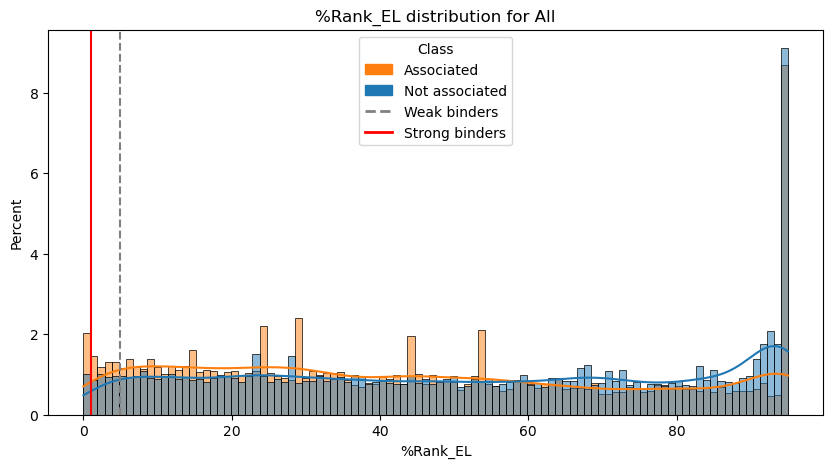

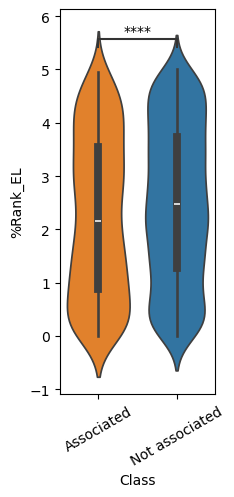

In [ ]:

out_only_elisa_associated = out_only_elisa[out_only_elisa['Class'] == 'Associated']
out_only_elisa_not_associated = out_only_elisa[out_only_elisa['Class'] == 'Not associated']

plot_rank_distribution_in_percentage(out_only_elisa_associated, out_only_elisa_not_associated, bins=100, custom_palette=custom_palette, loc='best')

df_test = out_only_elisa[out_only_elisa['%Rank_EL'] <= 5]
plt.figure(figsize=(2,5))
# ax =sns.boxplot(data=df_test, x='Class', y='%Rank_EL', hue='Class')

ax =sns.violinplot(data=df_test, x='Class', y='%Rank_EL', hue='Class', hue_order=['Not associated', 'Associated'])
plt.xticks(rotation=30)

# Get unique class names
classes = df_test['Class'].unique()
pair = [(classes[0], classes[1])]

# Run the t-test
data1 = df_test[df_test['Class'] == classes[0]]['%Rank_EL']
data2 = df_test[df_test['Class'] == classes[1]]['%Rank_EL']
# stat, pval = ttest_ind(data1, data2, equal_var=False)

# Add significance annotation
annotator = Annotator(ax, pair, data=df_test, x='Class', y='%Rank_EL')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=1)
annotator.apply_and_annotate()


## Second case: Comparison HLA peptide binding in associated proteins vs non HLA-II associated Proteins (taken randomly from only tested set in the GWAS analysis. n=84) ###

(<Axes: xlabel='Class', ylabel='%Rank_EL'>,
 [<statannotations.Annotation.Annotation at 0x337bf24d0>])

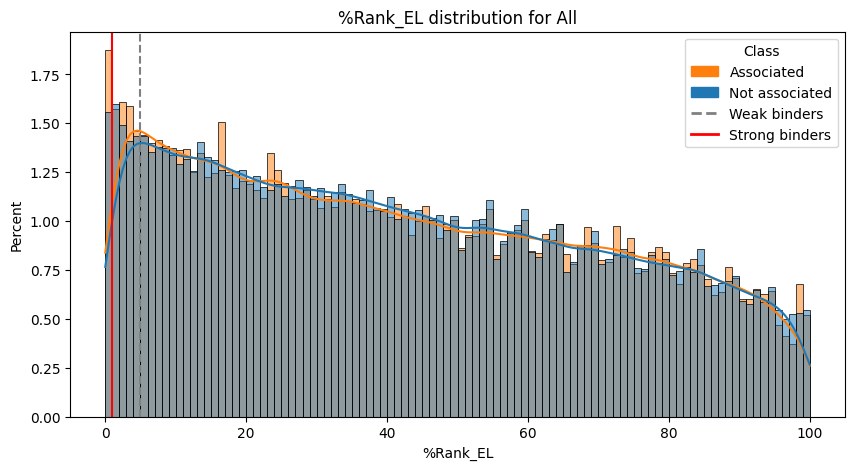

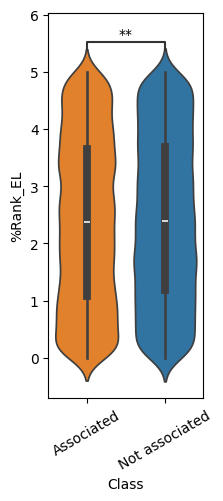

In [ ]:
summary_associated['Class'] = 'Associated'
summary_not_associated['Class'] = 'Not associated'
plot_rank_distribution_in_percentage(summary_associated, summary_not_associated, bins=100, custom_palette=custom_palette, loc='upper right')

df_test = pd.concat([summary_associated, summary_not_associated])
df_test = df_test[df_test['%Rank_EL'] <= 5]
plt.figure(figsize=(2,5))
# ax =sns.boxplot(data=df_test, x='Class', y='%Rank_EL', hue='Class')
ax = sns.violinplot(data=df_test, x='Class', y='%Rank_EL', hue='Class', hue_order=['Not associated', 'Associated'])
plt.xticks(rotation=30)
# sns.stripplot(data=df_test, x='Class', y='%Rank_EL', alpha=.03, color='grey')
# Get unique class names
classes = df_test['Class'].unique()
pair = [(classes[0], classes[1])]

# Run the t-test
data1 = df_test[df_test['Class'] == classes[0]]['%Rank_EL']
data2 = df_test[df_test['Class'] == classes[1]]['%Rank_EL']
# stat, pval = ttest_ind(data1, data2, equal_var=False)

# Add significance annotation
annotator = Annotator(ax, pair, data=df_test, x='Class', y='%Rank_EL')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annotator.apply_and_annotate()

## Comparing the associated proteins binding vs. all possible combinations of non associated proteins and the associated alleles.

(<Axes: xlabel='Class', ylabel='%Rank_EL'>,
 [<statannotations.Annotation.Annotation at 0x2c4dbbb50>])

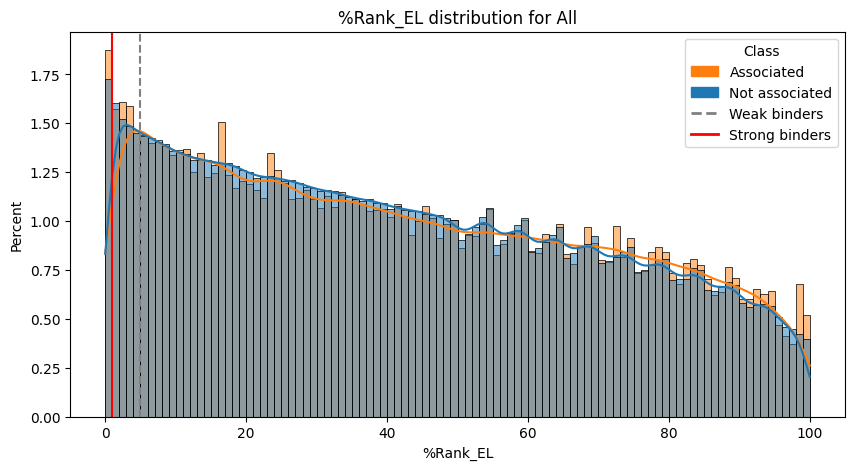

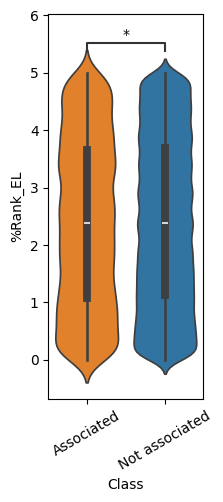

In [ ]:

summary_associated['Class'] = 'Associated'
summary_non_associated_binders_all_combinations['Class'] = 'Not associated'
plot_rank_distribution_in_percentage(summary_associated, summary_non_associated_binders_all_combinations, bins = 100, custom_palette=custom_palette, loc='upper right')


df_test = pd.concat([summary_associated, summary_non_associated_binders_all_combinations])
df_test = df_test[df_test['%Rank_EL'] <= 5]
plt.figure(figsize=(2,5))
# ax =sns.boxplot(data=df_test, x='Class', y='%Rank_EL', hue='Class')
ax = sns.violinplot(data=df_test, x='Class', y='%Rank_EL', hue='Class', hue_order=['Not associated', 'Associated'])
plt.xticks(rotation=30)
# sns.swarmplot(data=df_test, x='Class', y='%Rank_EL')
# Get unique class names
classes = df_test['Class'].unique()
pair = [(classes[0], classes[1])]

# Run the t-test
data1 = df_test[df_test['Class'] == classes[0]]['%Rank_EL']
data2 = df_test[df_test['Class'] == classes[1]]['%Rank_EL']
# stat, pval = ttest_ind(data1, data2, equal_var=False)

# Add significance annotation
annotator = Annotator(ax, pair, data=df_test, x='Class', y='%Rank_EL')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annotator.apply_and_annotate()

### Analysis checking the Elution score, only for Binders in associated peptides vs. non-associated peptides

In [29]:
EL_levels = np.arange(0.99, 0.79, -0.01)

summary_associated['Class'] = 'Associated'
summary_not_associated['Class'] = 'Not associated'
summary_associated_bind = summary_associated[summary_associated['%Rank_EL'] <=5]
summary_not_associated_bind = summary_not_associated[summary_not_associated['%Rank_EL'] <=5]


plot_rank_distribution_in_percentage(summary_associated_bind, summary_not_associated_bind, bins=20, loc='upper right')
plt.axvline(x=5.,color='grey')
plt.axvline(x=1.,color='red')
list_EL_associated = []
list_EL_not_associated = []
for level in EL_levels:
    summary_associated['Score_EL'] = summary_associated['Score_EL'].astype(float)
    list_EL_associated.append(len(summary_associated[summary_associated['Score_EL'] > level]) / len(summary_associated))
    summary_non_associated_binders_all_combinations['Score_EL'] = summary_non_associated_binders_all_combinations['Score_EL'].astype(float)
    list_EL_not_associated.append(len(summary_non_associated_binders_all_combinations[summary_non_associated_binders_all_combinations['Score_EL'] > level]) / len(summary_non_associated_binders_all_combinations))

EL_levels_factorized = [f'>{str(round(x,2))}' for x in EL_levels]
comparison_EL_scores_associated = pd.DataFrame({'Proportion of Binders Found on total positions' : list_EL_associated, 'EL score levels' : EL_levels_factorized, 'Class' : 'Associated'})
comparison_EL_scores_not_associated = pd.DataFrame({'Proportion of Binders Found on total positions' : list_EL_not_associated, 'EL score levels' : EL_levels_factorized, 'Class' : 'Not Associated'})
comparison_EL_scores = pd.concat([comparison_EL_scores_associated, comparison_EL_scores_not_associated])
comparison_EL_scores.sort_values(by='EL score levels', ascending=False, inplace=True)
comparison_EL_scores['EL score levels'] = comparison_EL_scores['EL score levels'].astype('category')
# Reverse the order of categories
comparison_EL_scores['EL score levels'] = comparison_EL_scores['EL score levels'].cat.reorder_categories(
    comparison_EL_scores['EL score levels'].cat.categories[::-1], ordered=True
)

plt.figure(figsize=(10,4))
sns.lineplot(data=comparison_EL_scores, x='EL score levels', y='Proportion of Binders Found on total positions', hue='Class');
plt.yscale('log')
plt.xticks(rotation=90);


TypeError: '<=' not supported between instances of 'str' and 'int'